# Model 1 - Horizontal stratigraphic

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,2,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_interfaces_slice.csv")


In [3]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

In [4]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}

geo_data.set_colors(colormodel)

cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

geo_data.formations

,value,formation_number,color
rock2,1,1,#0057e7
rock1,2,2,#d62d20
basement,3,3,#ffa700


In [5]:
geo_data.set_colors(colormodel)

,value,formation_number,color
rock2,1,1,#0057e7
rock1,2,2,#d62d20
basement,3,3,#ffa700


In [6]:
cmap.colors

['#0057e7', '#d62d20', '#ffa700']

In [7]:
#%matplotlib inline
#gp.get_sequential_pile(geo_data)

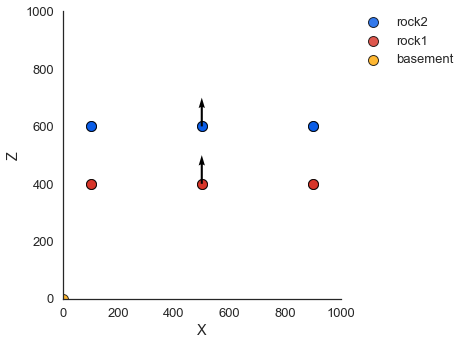

In [8]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [9]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '10336')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\Jan\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.6.4-64\lock_dir


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [10]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


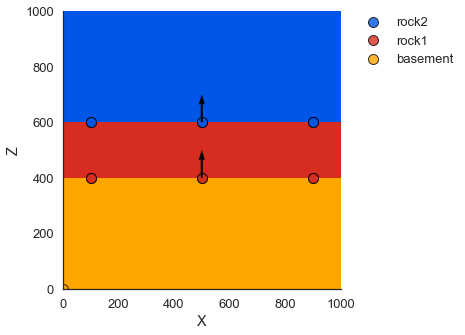

In [11]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model1_pure', edgecolor='black')

In [12]:
import gempy.utils.Kriging_Jan as krige

In [13]:
d = {'X': [500, 500], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  500  10  500        20
1  500  10  500        20


In [14]:
np.random.seed(524601254)

In [15]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='euclidian', an_factor=1, var_par=(200,50,1))

initializing: 0.014007329940795898
distance precalculation: 0.4077646732330322
submatrix extraction: 0.013985157012939453
distance Matrices: 0.46883487701416016
kriging calculation: 0.792504072189331
Negative Variances: 0
Out of: 4001


In [16]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

In [17]:
colormodel = {'basement':'#696969','rock1':'#A0A0A0','rock2':'#BEBEBE','rock3':'#008744','fault':'#17202a'}

geo_data.set_colors(colormodel)

cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

geo_data.formations

,value,formation_number,color
rock2,1,1,#BEBEBE
rock1,2,2,#A0A0A0
basement,3,3,#696969


In [18]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

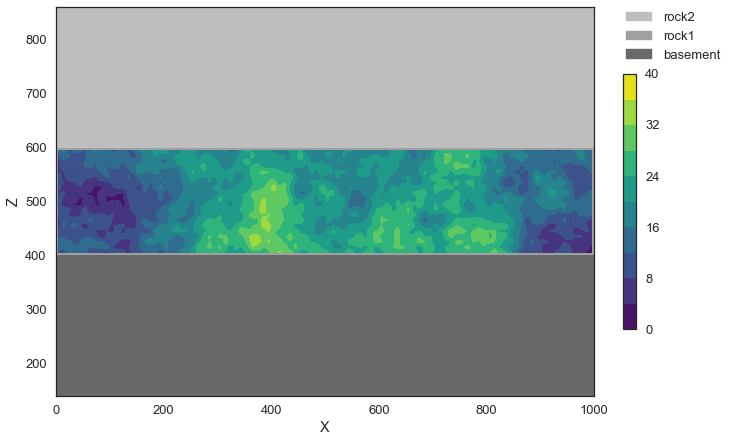

In [19]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=0, vmax=40)
v = np.linspace(0, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

#plt.savefig(fname='Basic_SGSfield_200_50_1_deformedB', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [20]:
mean = np.mean(test.kriging_result[1])
max_val = np.max(test.kriging_result[1])
min_val = np.min(test.kriging_result[1])
variance = np.var(test.kriging_result[1])
std = np.sqrt(variance)


Text(0.5,1,'Histogram using 50 bins')

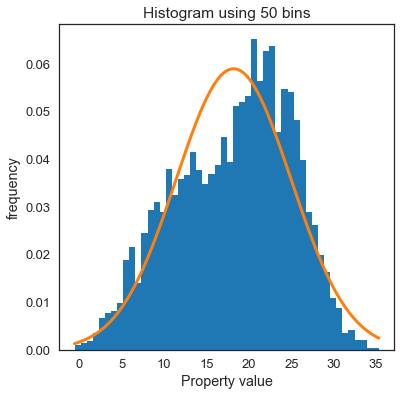

In [21]:
import scipy

fig = plt.figure(figsize = (6, 6)) 
#show histogram (normal and cumulative)
bin_amount = 50

x_vals = np.arange(min_val, max_val, 0.1)

plt.hist(test.kriging_result[1], bins=bin_amount, normed=True);
plt.plot(x_vals, scipy.stats.norm.pdf(x_vals, mean, std), lw = 3)
plt.xlabel("Property value")
plt.ylabel("frequency")
plt.title('Histogram using %i bins' %bin_amount)

#plt.savefig(fname='Basic_SGSfield_200_50_1_deformedB_hist', edgecolor='black', bbox_inches='tight')

In [22]:
'''
coord_dist = test.result_coord[:3]
dist_plt = test.dist_matrix_plt[:,1]
combined = np.vstack((coord_dist, dist_plt))
combined = np.swapaxes(combined,0,1)
combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=0, vmax=600)
v = np.linspace(0, 600,11, endpoint=True)

c = plt.scatter(x=coord_dist[0,0], y=coord_dist[2,0], c='black', s=50, marker='o',zorder=3)

a = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)
b = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.colorbar(a, orientation='vertical', fraction=0.019, pad=0.06)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.savefig(fname='Distancefield__deformedA_modelA_an=1', edgecolor='black', bbox_inches='tight')
'''

"\ncoord_dist = test.result_coord[:3]\ndist_plt = test.dist_matrix_plt[:,1]\ncombined = np.vstack((coord_dist, dist_plt))\ncombined = np.swapaxes(combined,0,1)\ncombined_cut = np.where(combined[:,1]<10)[0]\ncombined_cut = combined[combined_cut]\ncombined_cut = combined_cut[:,[0,2,3]]\n\nX, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])\n\nnorm=matplotlib.colors.Normalize(vmin=0, vmax=600)\nv = np.linspace(0, 600,11, endpoint=True)\n\nc = plt.scatter(x=coord_dist[0,0], y=coord_dist[2,0], c='black', s=50, marker='o',zorder=3)\n\na = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)\nb = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)\n\ngp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,\n                         direction='y', plot_data=False, cmap=cmap, norm=None)\n\nplt.colorbar(a, orientation='vertical', fraction=0.019, pad=0.06)\n\nplt.axis('equal')\nplt.xlim(0,1000)\nplt.ylim(200,800)\n\nplt.savefig(fname='Distancefield__deformedA_modelA_a

In [23]:
# Sampling
def random_sampling(data):
    #print(len(data))
    rand_pos = np.random.randint(0,len(data),50)
    #print(rand_pos)
    #print(rand_pos.shape)
    samples = data[rand_pos]
    return samples

In [24]:
samples = random_sampling(combined)

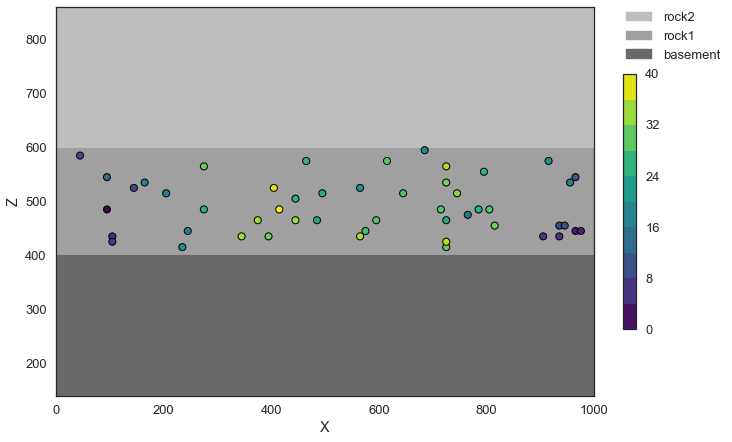

In [25]:
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.scatter(x=samples[:,0], y=samples[:,2], c=samples[:,3], s=50, cmap='viridis', linewidths=1, edgecolors='black')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Basic_SGSfield_200_50_1_samples', edgecolor='black')

In [26]:
d = {'X': samples[:,0], 'Y': samples[:,1], 'Z': samples[:,2], 'Property': samples[:,3]}
data_field = pd.DataFrame(data=d)
#print(data_field)

In [27]:
simulation = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='UK', distance_type='deformed_A')

initializing: 0.016986370086669922
Fault: False
10000
1
distance precalculation: 118.68557262420654


NameError: name 'data_v' is not defined

In [ ]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

In [ ]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

fig = plt.figure(figsize=(10, 7))

plt.contourf(X, Y, Z, cmap='viridis')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.colorbar(a, orientation='horizontal')
fig.tight_layout()

In [ ]:
print(test.grid_dataframe.head())

In [ ]:
print(lith_block[0].shape)

print(geo_data.grid.values[:, 0].shape)

In [ ]:
d = {'X': geo_data.grid.values[:, 0], 'Y': geo_data.grid.values[:, 1], 'Z': geo_data.grid.values[:, 2],
     'lithology': lith_block[0], 'scalar field value': lith_block[1]}
dataframe = pd.DataFrame(data=d)
print(dataframe.head())

In [ ]:
# create the dataframe and populate with data
d = {'X': geo_data.grid.values[:, 0], 'Y': geo_data.grid.values[:, 1], 'Z': geo_data.grid.values[:, 2],
    'lithology': lith_block[0], 'scalar field value': lith_block[1], 'fault block': fault_block[0]}


dataframe = pd.DataFrame(data=d)